## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

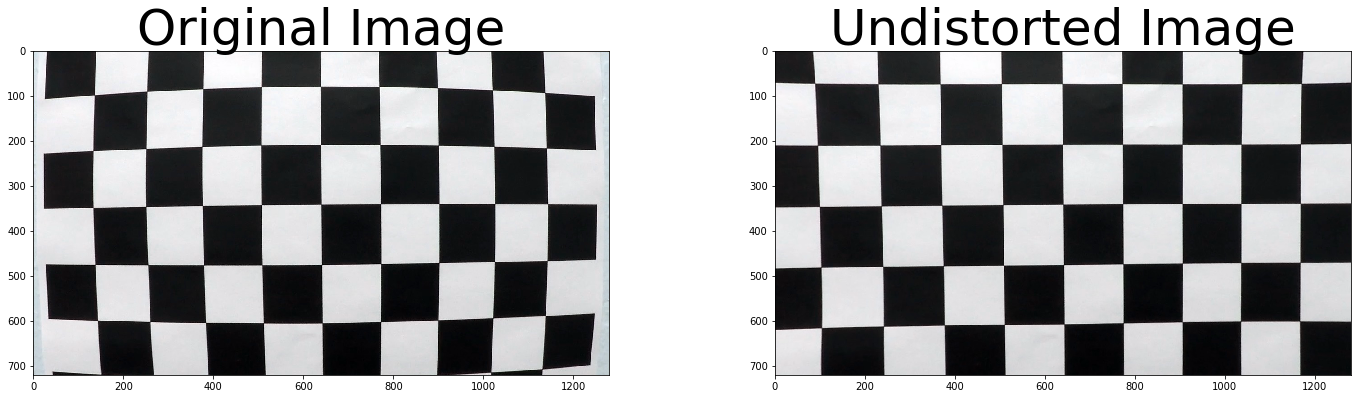

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
 
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

# camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

img = cv2.imread(images[0])
#print('img', img)
#print('mtx', mtx)
#print('dist', dist)
undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## Next I compute the transformation matrix

Text(0.5,1,'Warped Image with destination points')

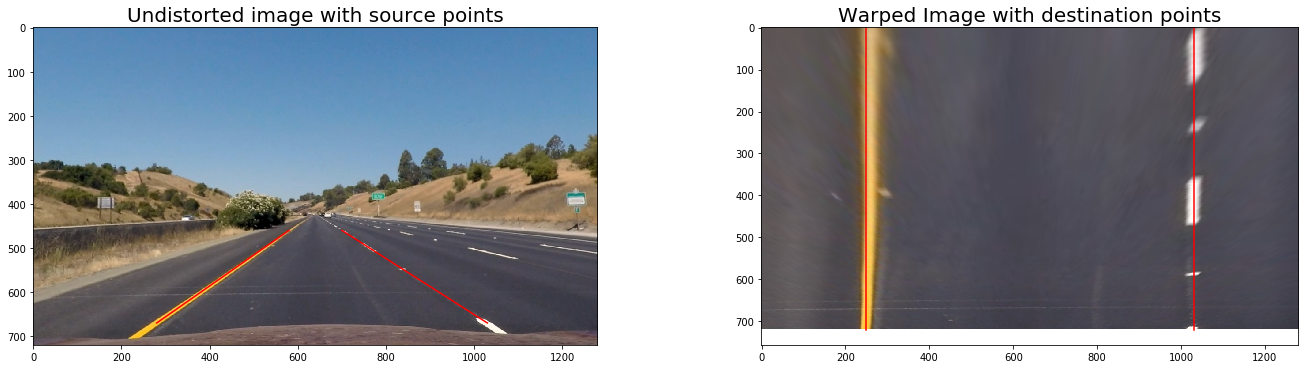

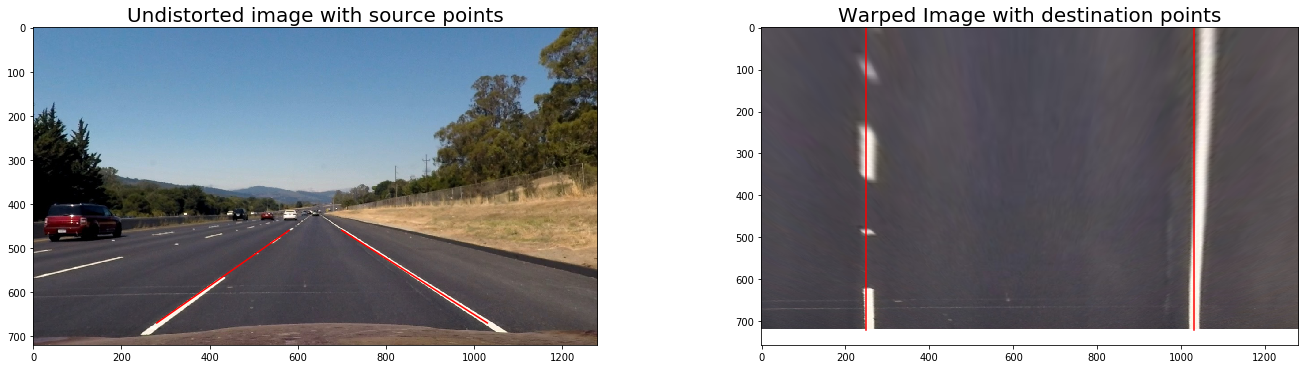

In [2]:
test_images = glob.glob('./test_images/*.jpg')
img0 = cv2.imread(test_images[0])
img1 = cv2.imread(test_images[1])


image_size = np.shape(img)
y_max = image_size[0]
x_max = image_size[1]

# source points
src = np.float32([[280, y_max-50], 
                [x_max/2-60, y_max/2+100], 
                [x_max/2+60, y_max/2+100], 
                [x_max-250, y_max-50]])
# destination points
dst = np.float32([[250, y_max], 
                [250, 0],
                [x_max-250, 0],
                [x_max-250, y_max]])

# get perspective transform
M = cv2.getPerspectiveTransform(src, dst)
# compute the inverse perspective transform
Minv = cv2.getPerspectiveTransform(dst, src)

#undistort image
undist0 = cv2.undistort(img0, mtx, dist, None, mtx)
undist1 = cv2.undistort(img1, mtx, dist, None, mtx)
# warp the image
img_size = (image_size[1], image_size[0])
warped0 = cv2.warpPerspective(undist0, M, img_size, flags=cv2.INTER_LINEAR)
warped1 = cv2.warpPerspective(undist1, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
f.tight_layout()
ax1.imshow(undist0[:,:,::-1])
ax1.plot((src[0][0], src[1][0]), (src[0][1], src[1][1]), 'r')
ax1.plot((src[2][0], src[3][0]), (src[2][1], src[3][1]), 'r')
ax1.set_title('Undistorted image with source points', fontsize=20)
ax2.imshow(warped0[:,:,::-1])
ax2.plot((dst[0][0], dst[1][0]), (dst[0][1], dst[1][1]), 'r')
ax2.plot((dst[2][0], dst[3][0]), (dst[2][1], dst[3][1]), 'r')
ax2.set_title('Warped Image with destination points', fontsize=20)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
f.tight_layout()
ax1.imshow(undist1[:,:,::-1])
ax1.plot((src[0][0], src[1][0]), (src[0][1], src[1][1]), 'r')
ax1.plot((src[2][0], src[3][0]), (src[2][1], src[3][1]), 'r')
ax1.set_title('Undistorted image with source points', fontsize=20)
ax2.imshow(warped1[:,:,::-1])
ax2.plot((dst[0][0], dst[1][0]), (dst[0][1], dst[1][1]), 'r')
ax2.plot((dst[2][0], dst[3][0]), (dst[2][1], dst[3][1]), 'r')
ax2.set_title('Warped Image with destination points', fontsize=20)

## Next I define some helper functions for gradient detection

In [3]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sbinary

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxybinary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    #print(dir_grad)
    # 5) Create a binary mask where direction thresholds are met
    sdirbinary = np.zeros_like(dir_grad)
    sdirbinary[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sdirbinary

def s_threshold(image, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def h_threshold(image, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    return binary

def l_threshold(image, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary

def r_threshold(image, thresh=(0, 255)):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

def g_threshold(image, thresh=(0, 255)):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    binary = np.zeros_like(G)
    binary[(G > thresh[0]) & (G <= thresh[1])] = 1
    return binary

def b_threshold(image, thresh=(0, 255)):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    binary = np.zeros_like(B)
    binary[(B > thresh[0]) & (B <= thresh[1])] = 1
    return binary

# Apply each of the thresholding functions
def threshold(image):
#     ksize = 9
#     gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(100, 100)) # 20, 100
#     grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 80))
#     mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
#     dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
#     s_binary = s_threshold(image, thresh=(90, 255))
#     h_binary = h_threshold(image, thresh=(40/2, 80/2))
#     l_binary = l_threshold(image, thresh=(40/2, 80/2))
    
    r_binary_w = r_threshold(image, thresh=(100,255))
    g_binary_w = g_threshold(image, thresh=(100,255))
    b_binary_w = b_threshold(image, thresh=(200,255))
    
    r_binary_y = r_threshold(image, thresh=(225,255))
    g_binary_y = g_threshold(image, thresh=(180,255))
    b_binary_y = b_threshold(image, thresh=(  0,170))
    
    h_binary_y = h_threshold(image, thresh=( 20, 45))
    l_binary_y = l_threshold(image, thresh=(120,200))
    s_binary_y = s_threshold(image, thresh=( 80,255))
    
    combined = np.zeros_like(r_binary_w, dtype=np.uint8)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((r_binary_w==1) & (g_binary_w==1) & (b_binary_w==1)) | 
             ((r_binary_y==1) & (g_binary_y==1) & (b_binary_y==1)) |
             ((h_binary_y==1) & (l_binary_y==1) & (s_binary_y==1))] = 1
    return combined

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    y_max = img_ref.shape[0]
    x_max = img_ref.shape[1]
    output[int(y_max-(level+1)*height):int(y_max-level*height), max(0,int(center-width/2)):min(int(center+width/2),x_max)]=1
    return output

def fitpolynom(image, window_width, window_height, margin):
    left_centroids = [] # Store the (left) window centroid positions per level 
    right_centroids = [] # Store the (right) window centroid positions per level
    left_y = [] # y coordinates of left windows
    right_y = [] # y coordinates of right windows
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical slice
    # and then np.convolve the vertical image slice with the window template
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    img_shape = np.shape(image)
    y_max = img_shape[0]
    x_max = img_shape[1]
    l_sum = np.sum(image[int(3/4*y_max):,:int(x_max/2)], axis = 0)
    l_conv = np.convolve(window, l_sum)
    l_center = np.mean(np.argwhere(l_conv == np.amax(l_conv))) - window_width/2
    #print(l_center)
    #l_center = np.argmax(np.convolve(window, l_sum)) - window_width[0]/2
    r_sum = np.sum(image[int(3/4*y_max):,int(x_max/2):], axis = 0)
    r_conv = np.convolve(window, r_sum)
    r_center = np.mean(np.argwhere(r_conv == np.amax(r_conv))) - window_width/2 + int(x_max/2)
    #r_center = np.argmax(np.convolve(window, r_sum)) - window_width[0]/2 + int(x_max/2)
    
    # Add what we found for the first layer
    left_centroids.append(l_center)
    right_centroids.append(r_center)
    left_y.append(y_max - int(window_height/2))
    right_y.append(y_max - int(window_height/2))
    #window_centroids.append((l_center, r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1, (int)(y_max/window_height)):
        window = np.ones(window_width) # Create our window template that we will use for convolutions
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[y_max-(level+1)*window_height:int(y_max-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width[level]/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin, x_max))
        if np.argwhere(conv_signal[l_min_index:l_max_index]).size > 0: # any points found
            l_center = int(np.mean(np.argwhere(conv_signal[l_min_index:l_max_index])) + l_min_index-offset)
            left_centroids.append(l_center)
            left_y.append(int(y_max-(level+0.5)*window_height))
        else:
            left_centroids.append(-1)
            left_y.append(-1)
            
        #l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin, x_max))
        if np.argwhere(conv_signal[r_min_index:r_max_index]).size > 0: # any points found
            r_center = int(np.mean(np.argwhere(conv_signal[r_min_index:r_max_index])) + r_min_index-offset)
            right_centroids.append(r_center)
            right_y.append(int(y_max-(level+0.5)*window_height))
        else:
            right_centroids.append(-1)
            right_y.append(-1)
        #r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index-offset
#         window_centroids.append((l_center, r_center))


        # Points used to draw all the left and right windows
    l_points = np.zeros_like(image)
    r_points = np.zeros_like(image)
        
    # Go through each level and draw the windows
    for level in range(0, len(left_centroids)):
        # Window_mask is a function to draw window areas
        if left_centroids[level] >= 0:
            l_mask = window_mask(window_width, window_height, image, left_centroids[level], level)
            # Add graphic points from window mask here tot total pixels found
            l_points[(l_points == 255) | (l_mask == 1)] = 255
        if right_centroids[level] >= 0:
            r_mask = window_mask(window_width, window_height, image, right_centroids[level], level)
            # Add graphic points from window mask here tot total pixels found
            r_points[(r_points == 255) | (r_mask == 1)] = 255
        
    # Draw the results
    # add both left and right window pixels togehter
    template = np.array(r_points+l_points, np.uint8) 
    # create a zero color channel
    zero_channel = np.zeros_like(template)
    # make window pixels green
    template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)
    # making the original road pixels 3 color channels
    warpage = np.dstack((image, image, image))*255
    # overlay the original road image with window results
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    
    
    leftx = np.array(left_centroids)
    leftx = leftx[leftx >= 0]
    lefty = np.array(left_y)
    lefty = lefty[lefty >= 0]
    #print(leftx)
    rightx = np.array(right_centroids)
    rightx = rightx[rightx >= 0]
    righty = np.array(right_y)
    righty = righty[righty >= 0]
    
    n_windows = int(image.shape[0]/window_height)
    #commony = np.flip(np.array(range(n_windows))*window_height + window_height/2, axis=0)
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, y_max-1, y_max)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    left_coords = np.int32(np.column_stack((left_fitx, ploty)))
    right_coords = np.int32(np.column_stack((right_fitx, ploty)))
        
    output = cv2.polylines(output, [left_coords], isClosed=False, color=(255,255,0), thickness=5)
    output = cv2.polylines(output, [right_coords], isClosed=False, color=(255,255,0), thickness=5)
    for i in range(len(left_centroids)):
        if left_centroids[i] >= 0:
            cv2.circle(output,(int(left_centroids[i]), int(left_y[i])), 10, (255,0,0), -1)
        if right_centroids[i] >= 0:
            cv2.circle(output,(int(right_centroids[i]), int(right_y[i])), 10, (255,0,0), -1)
    
    # Define conversion in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_max*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_max*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curve_m = np.mean([left_curverad, right_curverad])
    #print(left_curverad, 'm', right_curverad, 'm')
        
    # calculate position of vehicle w.r.t. lane center
    lanewidth_p = right_fitx[-1] - left_fitx[-1]  # width of lane in pixels
    posveh_p = lanewidth_p/2 + left_fitx[-1] # vehicle position in pixels
    # vehicle deviation in meter (positive: vehicle is left of center; negative: vehicle is right of center)
    devveh_m = (x_max/2 - posveh_p)*xm_per_pix 
    
    return output, left_fit, right_fit, curve_m, devveh_m

def unwarp(image, left_fit, right_fit, window_width, window_height, margin):
    # Extract left and right line pixel positions
#     leftx = np.array([seq for seq in window_centroids])
#     rightx = np.array([seq[1] for seq in window_centroids])
#     leftx = np.array(left_centroids)
#     rightx = np.array(right_centroids)
#     n_windows = int(image.shape[0]/window_height)
#     commony = np.flip(np.array(range(n_windows))*window_height + window_height/2, axis=0)
    # Fit a second order polynomial to each
#     left_fit = np.polyfit(commony, leftx, 2)
#     right_fit = np.polyfit(commony, rightx, 2)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, y_max-1, y_max)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    left_coords = np.int32(np.column_stack((left_fitx, ploty)))
    right_coords = np.int32(np.column_stack((right_fitx, ploty)))
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))        # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
        
    # Draw the lane onto the onto the warped blank image
    warp_zero = cv2.fillPoly(warp_zero, np.int_([pts]), color=(0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    warp_zero = cv2.warpPerspective(warp_zero, Minv, (x_max, y_max))
        
        
    return warp_zero


    
def pipeline(image):
    undist = cv2.undistort(image[:,:,::-1], mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    combined = threshold(warped)
    
    window_width = 80
    window_height = 60
    margin = 160
    warp_window, left_fit, right_fit, curve_m, devveh_m = fitpolynom(combined, window_width, window_height, margin)
    newwarp = unwarp(warp_window, left_fit, right_fit, window_width, window_height, margin)
    output = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # add some text
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,50)
    fontScale              = 1.5
    fontColor              = (255,255,255)
    lineType               = 2
    cv2.putText(output,'Radius of Curve: {:06.2f} m'.format(curve_m), bottomLeftCornerOfText, font, fontScale, fontColor, lineType)
    # add vehicle deviation to lane center
    if devveh_m > 0: # vehicle is left of center
        direction = 'left of center'
    elif devveh_m < 0: # vehicle is right of center
        direction = 'right of center'
    else: # vehicle is at center of lane
        direction = 'at center'
    bottomLeftCornerOfText = (10,120)
    cv2.putText(output, ('Vehicle position: {:03.2f} m {}'.format(devveh_m, direction)), bottomLeftCornerOfText, font, fontScale, fontColor, lineType)
    
    #print(np.shape(output))
    return output, combined, warp_window



## Test on all test images

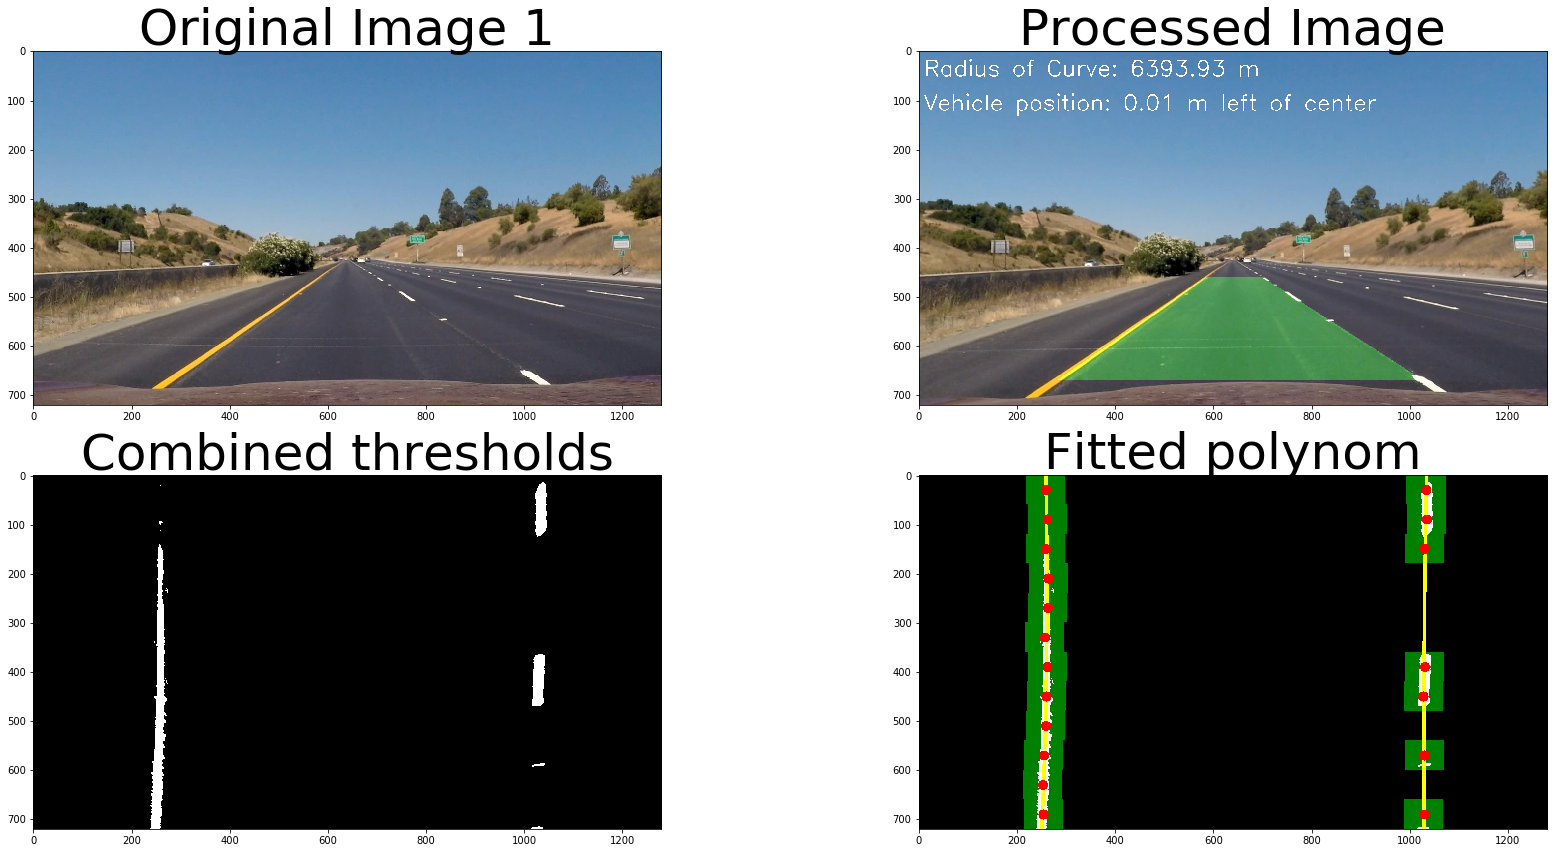

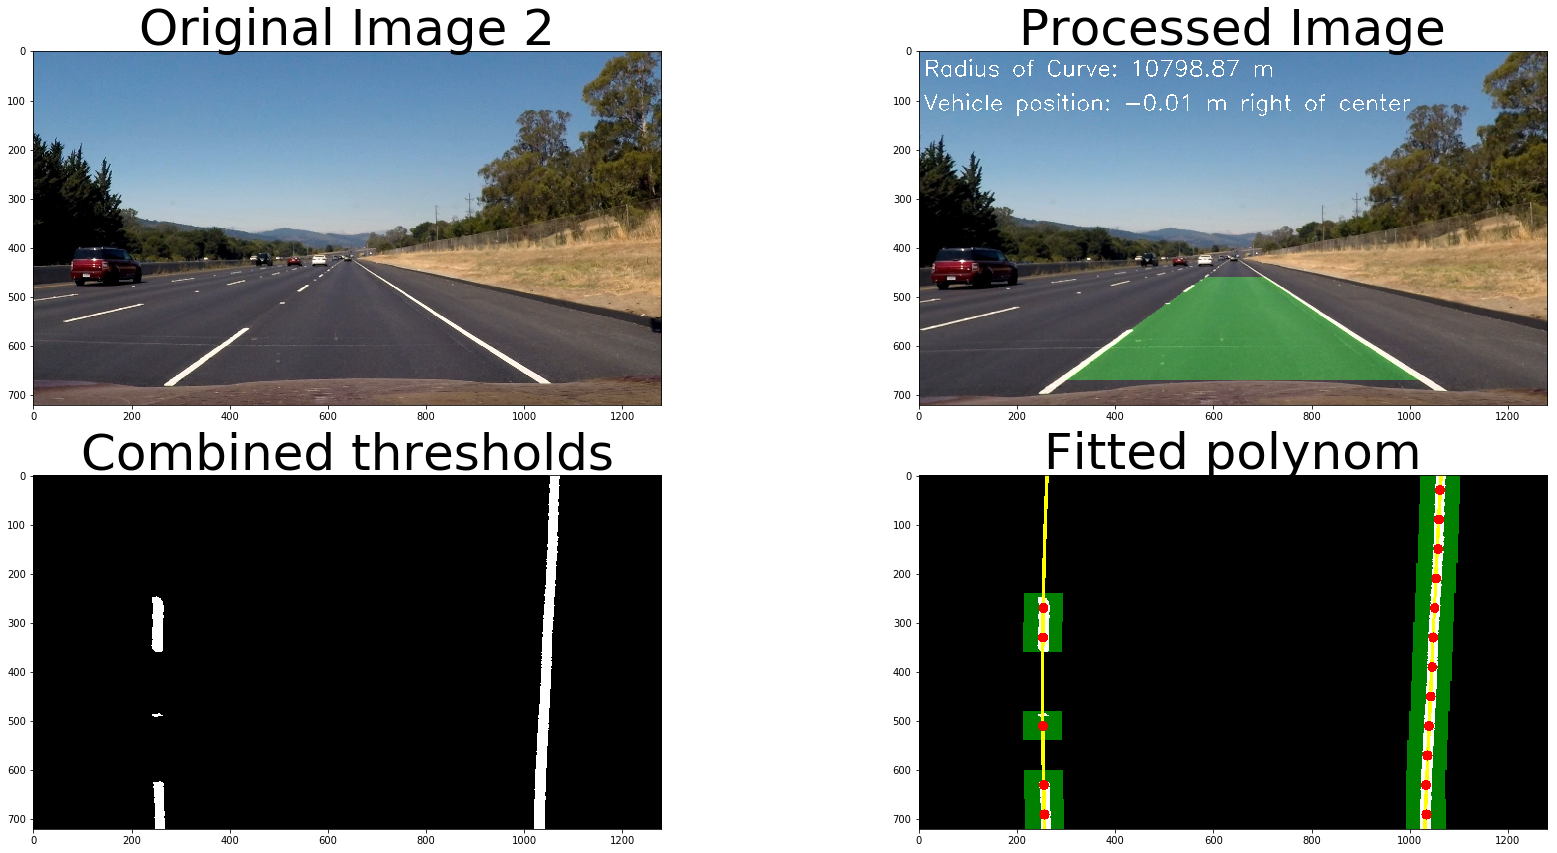

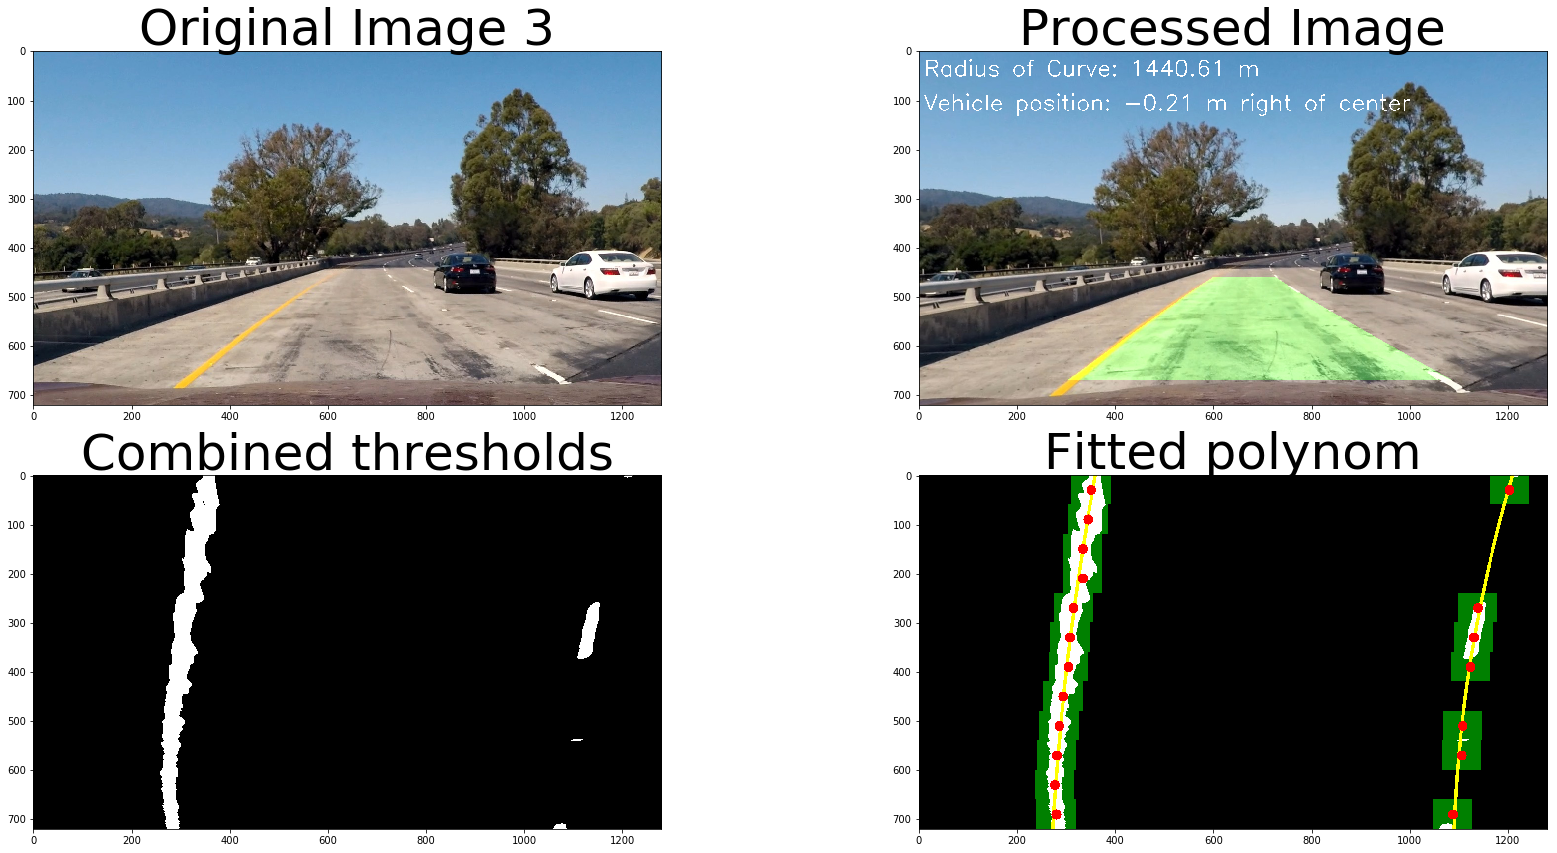

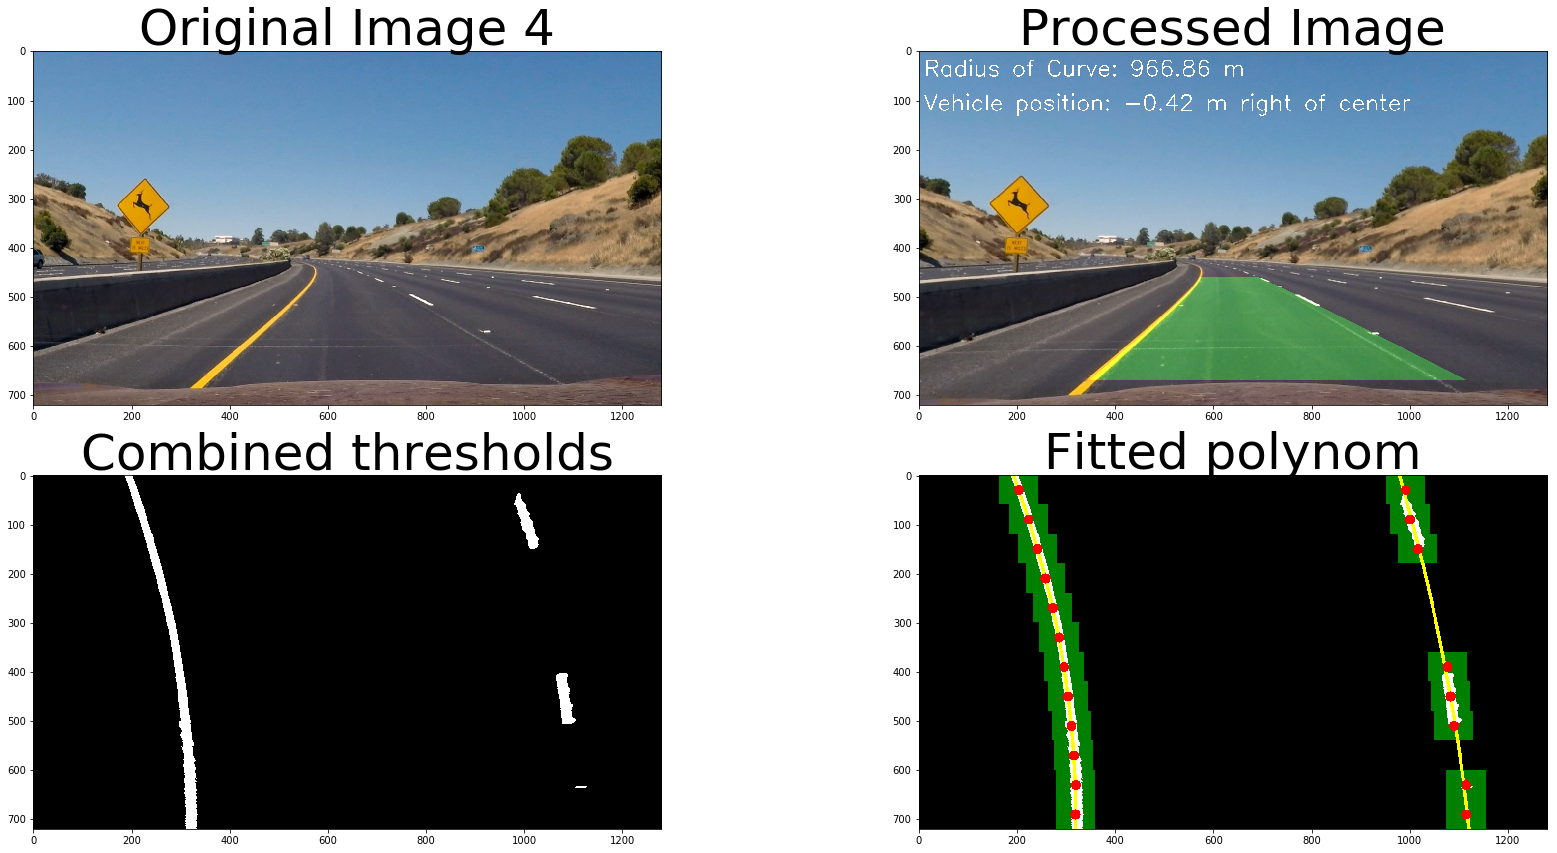

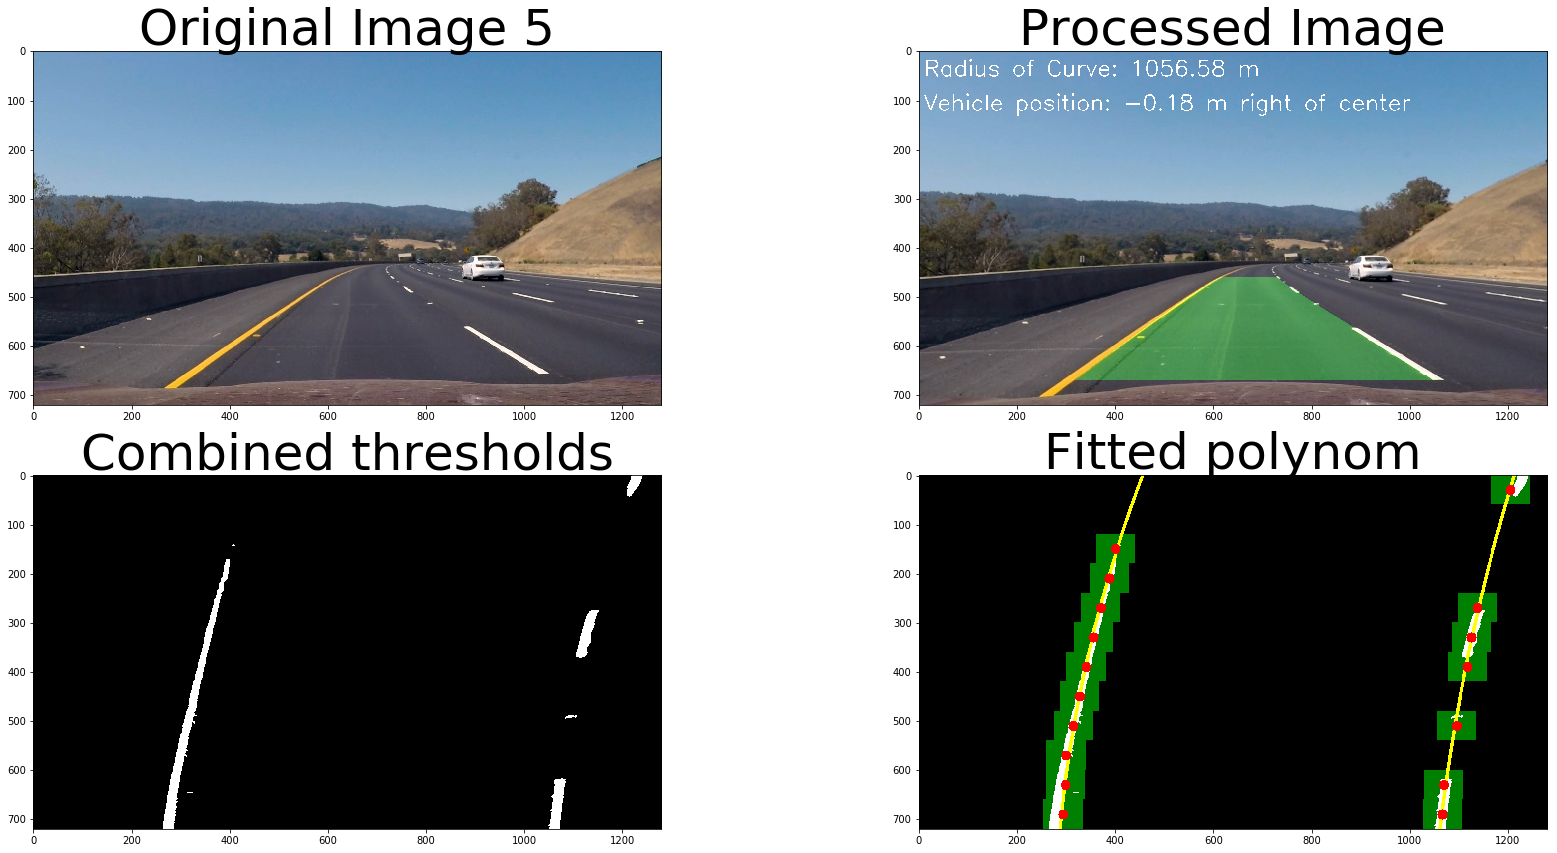

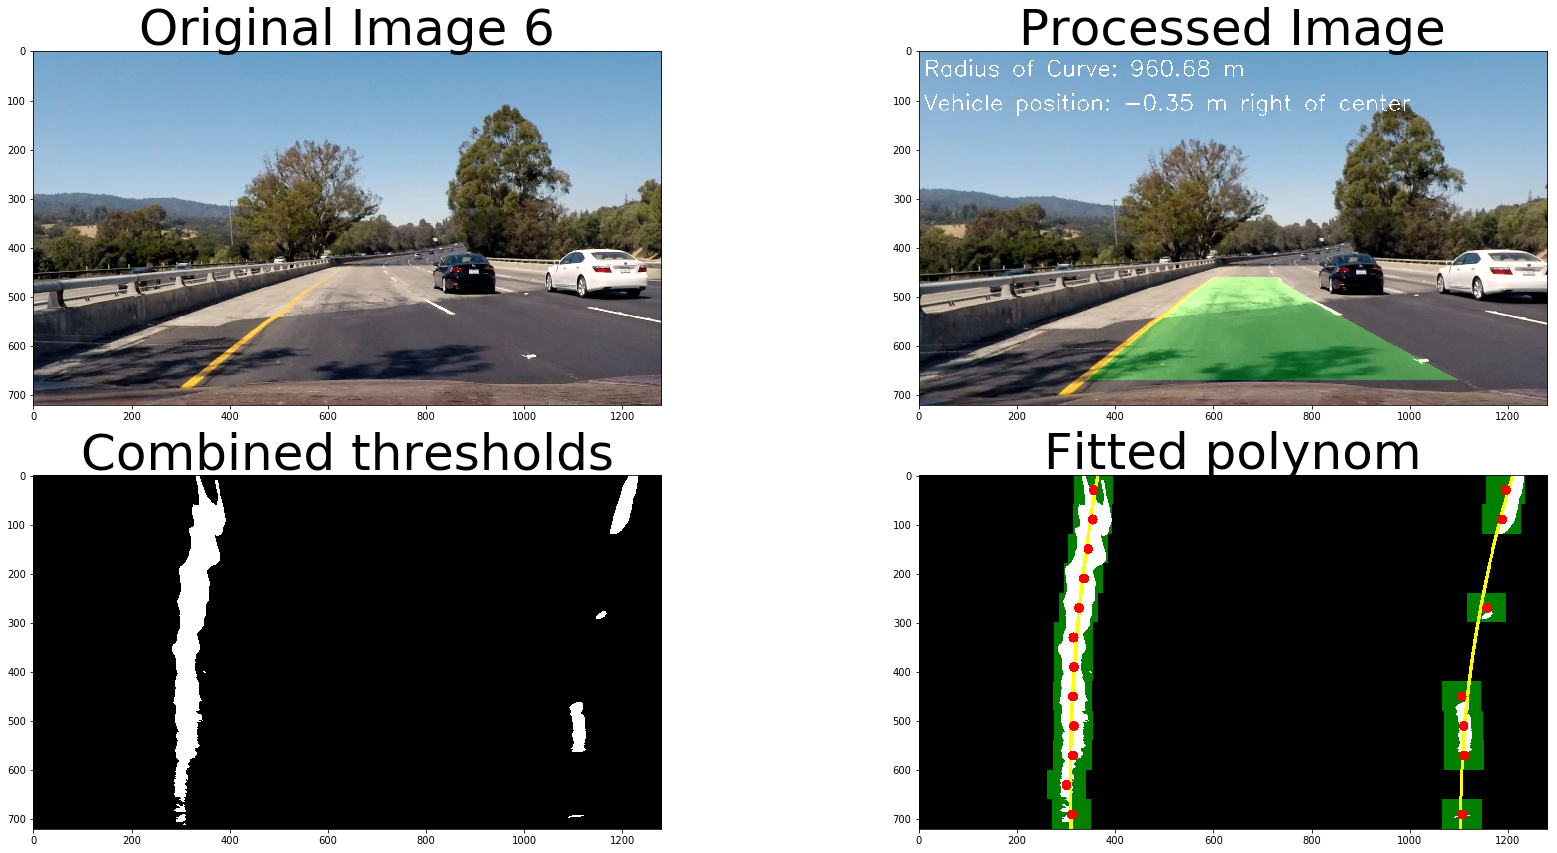

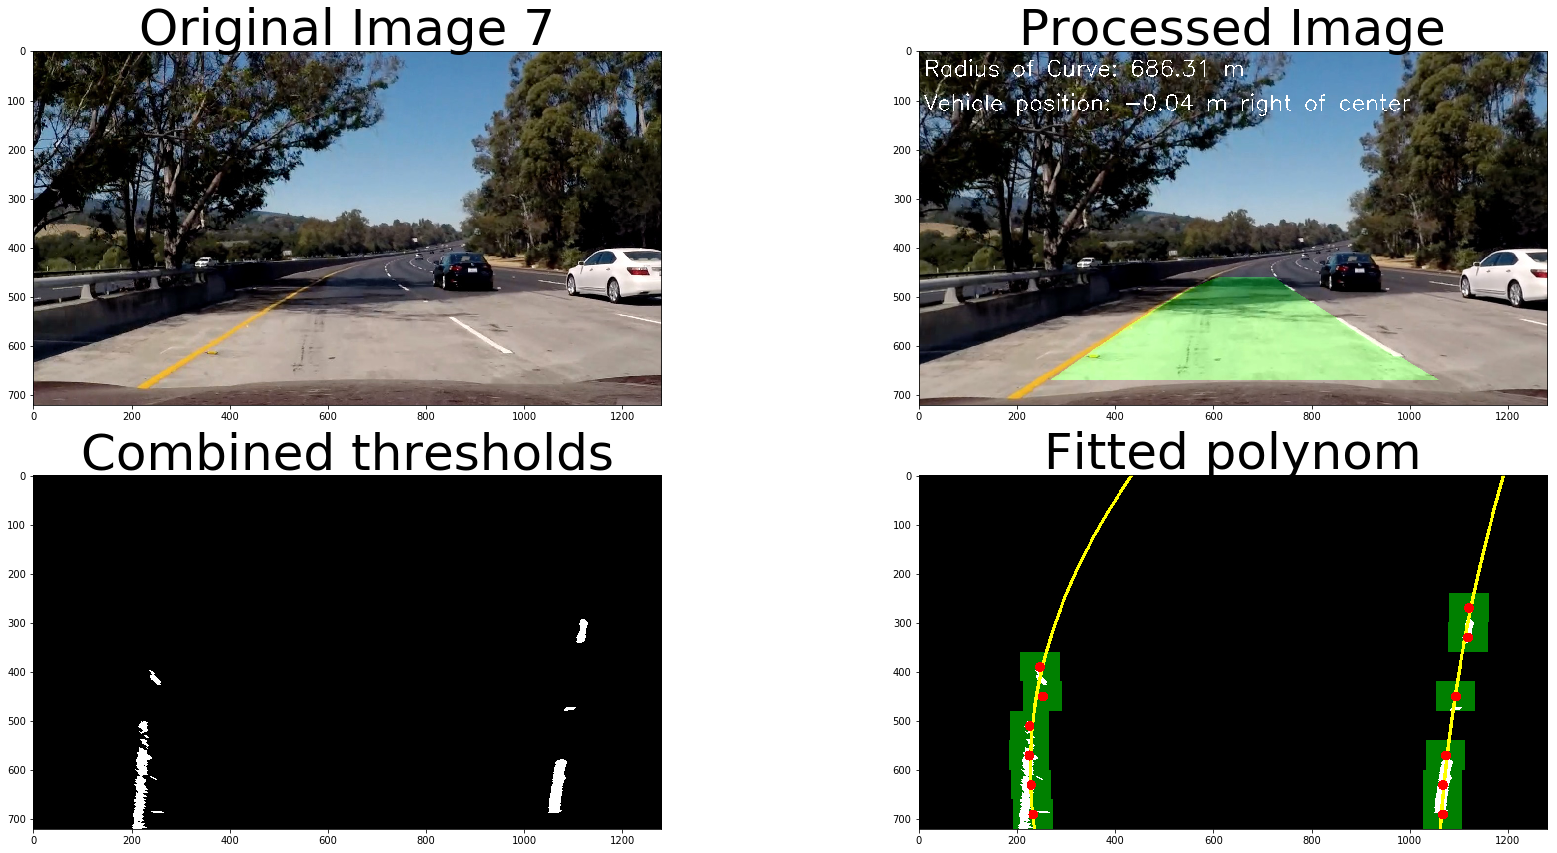

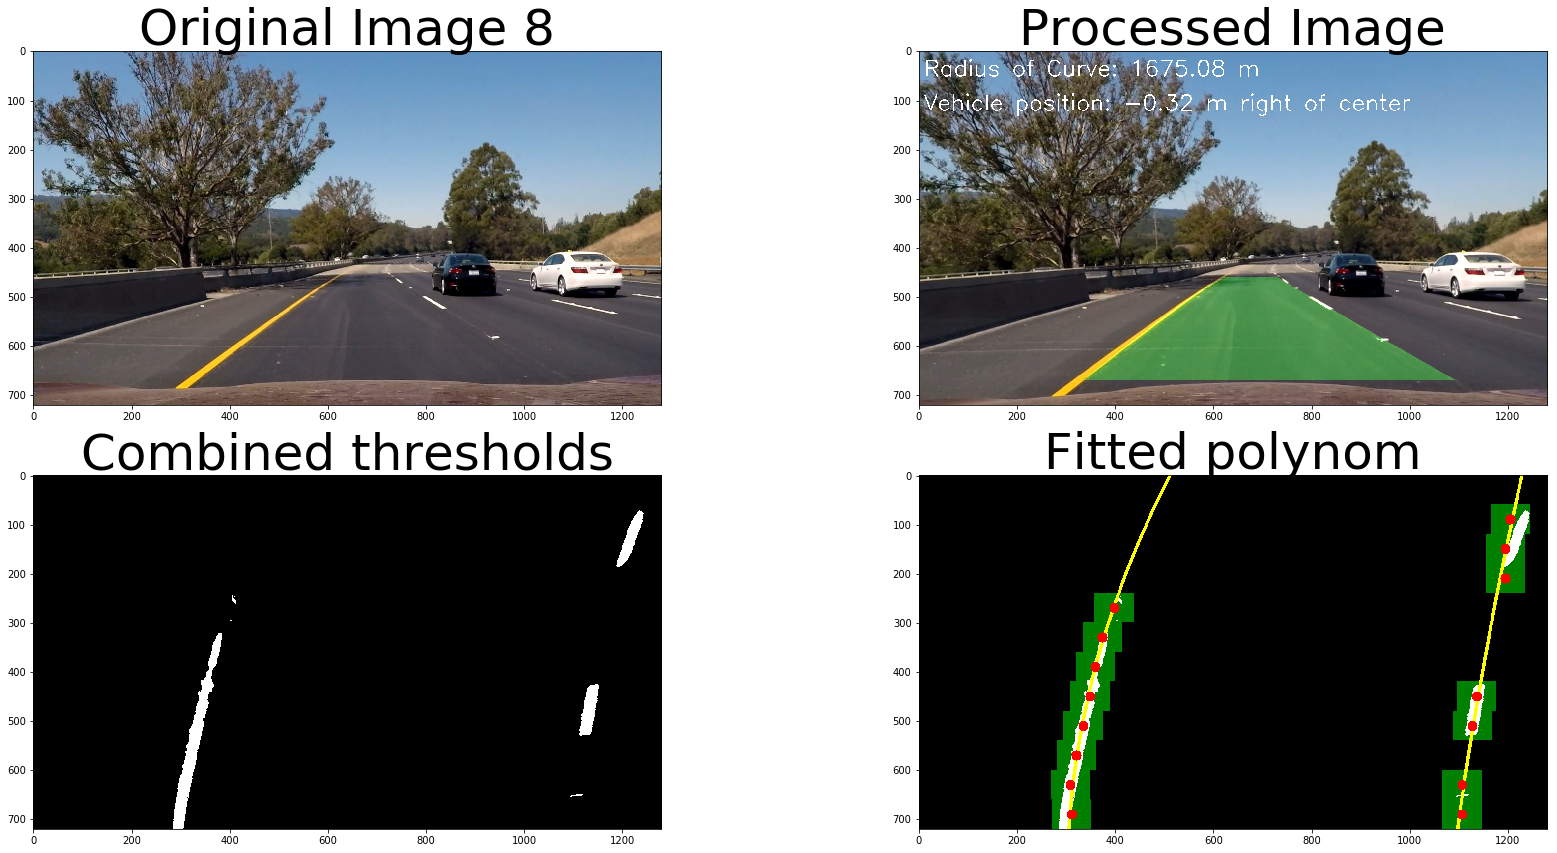

In [4]:
test_images = glob.glob('./test_images/*.jpg')

for i in range(len(test_images)):
    img = cv2.imread(test_images[i])

    processed, combined, warp_window = pipeline(img)

    # Plot the result
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 12))
    f.tight_layout()
    ax1.imshow(img[:,:,::-1])
    ax1.set_title('Original Image {}'.format(i+1), fontsize=50)
    ax2.imshow(processed, cmap='gray')
    ax2.set_title('Processed Image', fontsize=50)
    ax3.imshow(combined, cmap='gray')
    ax3.set_title('Combined thresholds', fontsize=50)
    ax4.imshow(warp_window, cmap='gray')
    ax4.set_title('Fitted polynom', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., hspace = 0.2)

## Use pipeline on video

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #print(np.shape(image))
    #print(image[1,1,1])
    
    
    result, combined, warp_window = pipeline(image[:,:,::-1])
    #print(np.shape(result))
    #print(result[:,:,:])
    
    return result

Identify lane lines on project video:

In [7]:
project_output = 'project_video_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")#.subclip(40,42)
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:27<00:00,  8.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 2min 28s


Show the video:

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))